In [1]:
# import necessary libraries
import hndlRas
import mbUtils
import warpRas
import geopandas as gpd
import rasterio
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import stats

In [2]:
# download raster files from google drive based on the blob id
# make sure that this folder's permissions are public (see hndlRas.py)
# define starting and ending slice of string indices representing
# the date in YYYYMMDD format

# if files are already downloaded from previous runs
if len(glob.glob('*.tif')) > 1:
    files = hndlRas.readTif(stSlice = 0, enSlice = 8)
    
# if need to download
else:
    files = hndlRas.arrTif('1ssN0OgL_nJZUHzTrj8r5jLhRn8dKPrg4',stSlice = 0,\
                    enSlice = 8)
# visualize output file structure and corresponding dates
files

,fname,time
0,20090604_1939_1020010008A18900_1020010008C45D0...,2009-06-04
1,20140823_1932_10200100324CCF00_10200100341F530...,2014-08-23
2,20141108_1948_103001003A904300_103001003ABC580...,2014-11-08
3,20150501_1922_103001004171B700_10300100416B2D0...,2015-05-01
4,20150818_1939_104001000F1D3000_1040010010D7CB0...,2015-08-18
5,20130603_1915_10200100236DC700_1020010021A8860...,2013-06-03
6,20160507_2209_102001004F892100_10200100503E1A0...,2016-05-07
7,20111115_1931_1020010015710400_102001001760340...,2011-11-15
8,20150503_2035_102001003B4F3C00_102001003CC8F30...,2015-05-03
9,20080926_1926_1020010004796700_1020010004B32D0...,2008-09-26


In [3]:
# sort files by date
fileSort = files.sort_values(by='time')
fileSort = fileSort.reset_index(drop=True)
fileSort

,fname,time
0,20080913_1929_10200100041CEF00_1020010003338C0...,2008-09-13
1,20080926_1926_1020010004796700_1020010004B32D0...,2008-09-26
2,20090604_1939_1020010008A18900_1020010008C45D0...,2009-06-04
3,20111115_1931_1020010015710400_102001001760340...,2011-11-15
4,20120708_1917_1050410000C47400_1050410000C4AA0...,2012-07-08
5,20120901_1921_10504100007F0300_105041000077540...,2012-09-01
6,20130603_1915_10200100236DC700_1020010021A8860...,2013-06-03
7,20140414_1905_102001002CD02100_102001002C0EBA0...,2014-04-14
8,20140513_1921_102001002B440E00_102001002D54E30...,2014-05-13
9,20140823_1932_10200100324CCF00_10200100341F530...,2014-08-23


In [4]:
# download shapefile for clip
glacShp = 'GlacOutline/OLYGlac_Output.shp'

In [5]:
# read outline into geopandas and sort by decreasing size
glacOutline = gpd.read_file(glacShp).sort_values(['Area_1'],ascending = False).reset_index(drop=True)

In [6]:
# define initial glacier class to be performed for each glacier outline
class GlacFeat:
    def __init__(self):
        self.z1 = None
        self.z2 = None
        self.dz = None
        self.dzdt = None

In [7]:
#instantiate data and time arrays
datArr = []
timArr = []
for i in range(0,20):
    #create an array of warped rasterio datasets
    warpRas.warpDEMs(files['fname'][0],\
        files['fname'][i],files['fname'][i])
    datArr.append(rasterio.open(files['fname'][i]))
    
    # create an array of dates in days forward from the first collection
    timArr.append((files['time'][i]-files['time'][0]).days)

timArr = np.ravel(timArr)

In [8]:
# list for concatenated numpy arrays
lister = []
featCount = 0
#for each glacier feature in the shapefile
for feat in enumerate(glacOutline['geometry']): 
    if featCount < 1:
        for i in range(0,20):
            # initialize glacier object
            gf = GlacFeat()
            # perform glacier clipping
            mbUtils.clip(gf,datArr[i],datArr[i],feat)
            lister.append(gf.z1[0][0])
            
    featCount += 1

# arrange a 3d datacube
datacube = np.stack(lister)
# initialize empty slope matrix
slopeArr = np.zeros((np.shape(gf.z1[0][0])))

In [9]:
# for each pixel, calculate the trend over time
# I am sure that there is a more efficient way of doing this
# still thinking about it
timeArr2 = np.ravel(timArr)
for yy in range(datacube[0].shape[0]):
    for xx in range(datacube[0].shape[1]):
        mask = ~np.isnan(datacube[:,yy,xx])
        if timeArr2[mask].size == 0:
            slopeArr[yy,xx] = np.nan
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(timeArr2[mask],datacube[mask,yy,xx])
            
            slopeArr[yy,xx] = slope

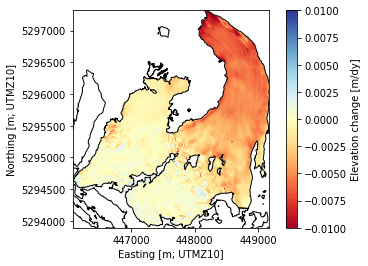

In [10]:
# plot elevation change trend
WV = glacOutline['geometry'][0]
extent = [WV.bounds[0],WV.bounds[2],WV.bounds[1],WV.bounds[3]]
glacOutline['geometry'].plot(facecolor='None',edgecolor='black')
plt.imshow(slopeArr,vmin=-0.01,vmax = 0.01,cmap='RdYlBu',extent = extent)

c = plt.colorbar()
plt.xlabel('Easting [m; UTMZ10]')
plt.ylabel('Northing [m; UTMZ10]')
c.ax.set_ylabel(ylabel='Elevation change [m/dy]')

plt.savefig('trendSpatial.png')

In [11]:
# bin slopes by elevation bands
bins = range(1000,2500,10)
mb = mbUtils.binbyElev(gf.z1[0][0],slopeArr,bins)

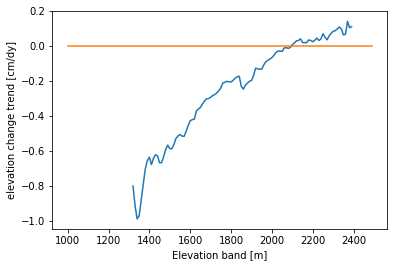

In [12]:
plt.figure()
plt.plot(bins[0:149],mb['mean'].values*100)
plt.plot([bins[0],bins[149]],[0,0])
plt.ylabel('elevation change trend [cm/dy]')
plt.xlabel('Elevation band [m]')

plt.savefig('trendTemporal.png')